# TF OD API

**Workspace Setup**

In [1]:
# Create Directories Inside Workspace Direcotry
# training, data, data/train_labels, data/test_labels
!mkdir workspace workspace/training workspace/data workspace/data/train_labels workspace/data/test_labels

# Copy Training Data to Workspace
!cp -r ../input/labeled-mask-dataset-pascal-voc-format/labeled_mask_dataset/annotations workspace/data
!cp -r ../input/labeled-mask-dataset-pascal-voc-format/labeled_mask_dataset/images workspace/data

# Train Test Split

# lists the files inside 'annotations' in a random order (not really random, by their hash value instead)
# Moves the first 274/1370 labels (20% of the labels) to the testing dir: `test_labels`
!ls workspace/data/annotations/* | sort -R | head -274 | xargs -I{} mv {} workspace/data/test_labels/


# Moves the rest of the labels ( 1096 labels ) to the training dir: `train_labels`
!ls workspace/data/annotations/* | xargs -I{} mv {} workspace/data/train_labels/

sort: write failed: 'standard output': Broken pipe
sort: write error


In [2]:
import os
import glob
import xml.etree.ElementTree as ET
import pandas as pd
import tensorflow as tf
import shutil

os.getcwd()

'/kaggle/working'

In [3]:
print(len(os.listdir('workspace/data/train_labels/')), len(os.listdir('workspace/data/test_labels/')))

1096 274


**Creating CSV from XML and Label Map**

In [4]:
def xml_to_csv(path):
    classes_names = []
    xml_list = []

    for xml_file in glob.glob(path + "/*.xml"):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall("object"):
            classes_names.append(member[0].text)
            value = (
                root.find("filename").text,
                int(root.find("size")[0].text),
                int(root.find("size")[1].text),
                member[0].text,
                int(member[4][0].text),
                int(member[4][1].text),
                int(member[4][2].text),
                int(member[4][3].text),
            )
            xml_list.append(value)
    column_name = ["filename", "width", "height", "class", "xmin", "ymin", "xmax", "ymax"]
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    classes_names = list(set(classes_names))
    classes_names.sort()
    return xml_df, classes_names

In [5]:
%cd workspace/data

/kaggle/working/workspace/data


In [6]:
for label_path in ["train_labels", "test_labels"]:
    image_path = os.path.join(os.getcwd(), label_path)
    xml_df, classes = xml_to_csv(label_path)
    xml_df.to_csv(f"{label_path}.csv", index=None)
    print(f"Successfully converted {label_path} xml to csv.")

label_map_path = os.path.join("label_map.pbtxt")
pbtxt_content = ""

for i, class_name in enumerate(classes):
    pbtxt_content = pbtxt_content + "item {{\n    id: {0}\n    name: '{1}'\n}}\n\n".format(i + 1, class_name)
pbtxt_content = pbtxt_content.strip()
with open(label_map_path, "w") as f:
    f.write(pbtxt_content)
    print("Successfully created label_map.pbtxt ")

Successfully converted train_labels xml to csv.
Successfully converted test_labels xml to csv.
Successfully created label_map.pbtxt 


**TF OD API Installation**

In [7]:
%cd ../../

# clone the tensorflow models on the colab cloud vm
!git clone --q https://github.com/tensorflow/models.git

#navigate to /models/research folder to compile protos
%cd models/research

# Compile protos.
!protoc object_detection/protos/*.proto --python_out=.

# Install TensorFlow Object Detection API.
!cp object_detection/packages/tf2/setup.py .
!python -m pip install .

# testing the model builder
!python object_detection/builders/model_builder_tf2_test.py

/kaggle/working
/kaggle/working/models/research
Processing /kaggle/working/models/research
  Preparing metadata (setup.py) ... - \ done
     |████████████████████████████████| 352 kB 498 kB/s            
     |████████████████████████████████| 106 kB 9.1 MB/s            
  Installing build dependencies ... - \ | / - \ | / done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
     |████████████████████████████████| 2.1 MB 8.2 MB/s            
     |████████████████████████████████| 67 kB 4.5 MB/s             
     |████████████████████████████████| 99 kB 6.9 MB/s             
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 92 kB 9.4 MB/s             
     |████████████████████████████████| 636 kB 46.5 MB/s            
     |████████████████████████████████| 238 kB 44.2 MB/s            
     |████████████████████████████████| 511.7 MB 5.1 kB/s             
     |█████████████████

**Generating TF Records**

In [8]:
%cd ../../workspace/data

/kaggle/working/workspace/data


In [9]:
#Usage:  
#!python generate_tfrecord.py output.csv output_pb.txt /path/to/images output.tfrecords

#For train.record
!python ../../../input/tf-od-api-helper-scripts/generate_tfrecord.py train_labels.csv  label_map.pbtxt images/ train.record

#For test.record
!python ../../../input/tf-od-api-helper-scripts/generate_tfrecord.py test_labels.csv  label_map.pbtxt images/ test.record

groups: 100%|█████████████████████████████| 1096/1096 [00:01<00:00, 1054.56it/s]
Successfully created the TFRecords: /kaggle/working/workspace/data/train.record
groups: 100%|███████████████████████████████| 274/274 [00:00<00:00, 1001.77it/s]
Successfully created the TFRecords: /kaggle/working/workspace/data/test.record


**Downloading Pretrained Model Checkpoint**

[Checkpoints](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md)

In [10]:
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
!tar -xzvf ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz

--2022-07-24 04:02:54--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 173.194.210.128, 2607:f8b0:400c:c0f::80
Connecting to download.tensorflow.org (download.tensorflow.org)|173.194.210.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20515344 (20M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz’

ssd_mobilenet_v2_fp 100%[===================>]  19.56M  47.2MB/s    in 0.4s    

2022-07-24 04:02:55 (47.2 MB/s) - ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz’ saved [20515344/20515344]

ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/checkpoint
ssd_mobilenet_v2_fpnlite_320x320_coco17_tp

**Model Config**

You need to make the following changes:

* change num_classes to number of your classes.
* change test.record path, train.record path & labelmap path to the paths where you have created these files (paths should be relative to your current working directory while training).
* change fine_tune_checkpoint to the path of the directory where the downloaded checkpoint is.
* change fine_tune_checkpoint_type with value classification or detection depending on the type..
* change batch_size to any multiple of 8 depending upon the capability of your GPU. (eg:- 24,128,...,512).
* change num_steps to number of steps you want the detector to train.

In [11]:
# !cat ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config

In [12]:
%%writefile ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config
model {
  ssd {
    num_classes: 2
    image_resizer {
      fixed_shape_resizer {
        height: 320
        width: 320
      }
    }
    feature_extractor {
      type: "ssd_mobilenet_v2_fpn_keras"
      depth_multiplier: 1.0
      min_depth: 16
      conv_hyperparams {
        regularizer {
          l2_regularizer {
            weight: 3.9999998989515007e-05
          }
        }
        initializer {
          random_normal_initializer {
            mean: 0.0
            stddev: 0.009999999776482582
          }
        }
        activation: RELU_6
        batch_norm {
          decay: 0.996999979019165
          scale: true
          epsilon: 0.0010000000474974513
        }
      }
      use_depthwise: true
      override_base_feature_extractor_hyperparams: true
      fpn {
        min_level: 3
        max_level: 7
        additional_layer_depth: 128
      }
    }
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
        use_matmul_gather: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    box_predictor {
      weight_shared_convolutional_box_predictor {
        conv_hyperparams {
          regularizer {
            l2_regularizer {
              weight: 3.9999998989515007e-05
            }
          }
          initializer {
            random_normal_initializer {
              mean: 0.0
              stddev: 0.009999999776482582
            }
          }
          activation: RELU_6
          batch_norm {
            decay: 0.996999979019165
            scale: true
            epsilon: 0.0010000000474974513
          }
        }
        depth: 128
        num_layers_before_predictor: 4
        kernel_size: 3
        class_prediction_bias_init: -4.599999904632568
        share_prediction_tower: true
        use_depthwise: true
      }
    }
    anchor_generator {
      multiscale_anchor_generator {
        min_level: 3
        max_level: 7
        anchor_scale: 4.0
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspect_ratios: 0.5
        scales_per_octave: 2
      }
    }
    post_processing {
      batch_non_max_suppression {
        score_threshold: 0.01
        iou_threshold: 0.5
        max_detections_per_class: 10
        max_total_detections: 10
        use_static_shapes: false
      }
      score_converter: SIGMOID
    }
    normalize_loss_by_num_matches: true
    loss {
      localization_loss {
        weighted_smooth_l1 {
        }
      }
      classification_loss {
        weighted_sigmoid_focal {
          gamma: 2.0
          alpha: 0.25
        }
      }
      classification_weight: 1.0
      localization_weight: 1.0
    }
    encode_background_as_zeros: true
    normalize_loc_loss_by_codesize: true
    inplace_batchnorm_update: true
    freeze_batchnorm: false
  }
}
train_config {
  batch_size: 8
  data_augmentation_options {
    random_horizontal_flip {
    }
  }
  data_augmentation_options {
    random_crop_image {
      min_object_covered: 0.0
      min_aspect_ratio: 0.75
      max_aspect_ratio: 3.0
      min_area: 0.75
      max_area: 1.0
      overlap_thresh: 0.0
    }
  }
  sync_replicas: true
  optimizer {
    momentum_optimizer {
      learning_rate {
        cosine_decay_learning_rate {
          learning_rate_base: 0.07999999821186066
          total_steps: 50000
          warmup_learning_rate: 0.026666000485420227
          warmup_steps: 1000
        }
      }
      momentum_optimizer_value: 0.8999999761581421
    }
    use_moving_average: false
  }
  fine_tune_checkpoint: "/kaggle/working/workspace/data/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0"
  num_steps: 10_000
  startup_delay_steps: 0.0
  replicas_to_aggregate: 8
  max_number_of_boxes: 100
  unpad_groundtruth_tensors: false
  fine_tune_checkpoint_type: "detection"
  fine_tune_checkpoint_version: V2
}
train_input_reader {
  label_map_path: "/kaggle/working/workspace/data/label_map.pbtxt"
  tf_record_input_reader {
    input_path: "/kaggle/working/workspace/data/train.record"
  }
}
eval_config {
  metrics_set: "coco_detection_metrics"
  use_moving_averages: false
}
eval_input_reader {
  label_map_path: "/kaggle/working/workspace/data/label_map.pbtxt"
  shuffle: false
  num_epochs: 1
  tf_record_input_reader {
    input_path: "/kaggle/working/workspace/data/test.record"
  }
}

Writing ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config


**Training**

In [13]:
%cd ../../models/research/object_detection

/kaggle/working/models/research/object_detection


In [14]:
!python model_main_tf2.py --pipeline_config_path=../../../workspace/data/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config --model_dir=../../../workspace/training --alsologtostderr

/opt/conda/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.4.0 and strictly below 2.7.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,
2022-07-24 04:03:06.351040: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.7/site-packag

**Evaluating**

In [15]:
# !python model_main_tf2.py --pipeline_config_path=../../../workspace/data/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config --model_dir=../../../workspace/training/ --checkpoint_dir=../../../workspace/training/ --alsologtostderr

**Export and Inference**

In [16]:
!python exporter_main_v2.py --trained_checkpoint_dir=../../../workspace/training --pipeline_config_path=../../../workspace/data/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config --output_directory ../../../workspace/data/inference_graph

2022-07-24 12:47:03.606180: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-07-24 12:47:03.607160: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
W0724 12:47:03.915671 140550926305088 deprecation.py:628] From /opt/conda/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py:458: calling map_fn_v2 (from tensorflow.python.ops

In [17]:
import tensorflow as tf
import time
import numpy as np
import warnings
import cv2
warnings.filterwarnings('ignore')
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
IMAGE_SIZE = (12, 8)
PATH_TO_SAVED_MODEL="../../../workspace/data/inference_graph/saved_model"
print('Loading model...', end='')

detect_fn=tf.saved_model.load(PATH_TO_SAVED_MODEL)
print('Done!')

def load_image_into_numpy_array(path):
    return np.array(Image.open(path))

image_path = "../../../workspace/data/images/134.jpg"
image_np = load_image_into_numpy_array(image_path)
input_tensor = tf.convert_to_tensor(image_np)
input_tensor = input_tensor[tf.newaxis, ...]

detections = detect_fn(input_tensor)
num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

Loading model...

2022-07-24 12:47:57.032115: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-24 12:47:57.135329: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-24 12:47:57.136151: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-24 12:47:57.137695: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Done!


2022-07-24 12:48:08.576031: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-07-24 12:48:10.315373: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


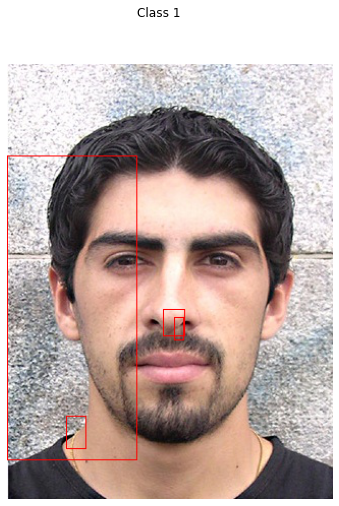

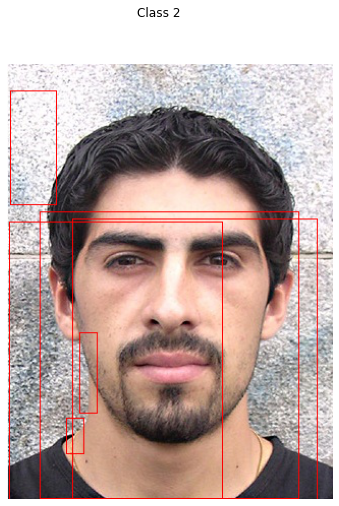

In [19]:
for class_idx in [1, 2]:
    image_np_with_detections = image_np.copy()
    for idx in range(num_detections):
        if detections['detection_classes'][idx] == class_idx:
            xmin, xmax, ymin, ymax = bbox = detections['detection_boxes'][idx]
            xmin, xmax, ymin, ymax = int(xmin*320), int(xmax*320), int(ymin*428), int(ymax*428)
            cv2.rectangle(image_np_with_detections, (xmin, ymin), (xmax, ymax), (255,0, 0))
    plt.figure(figsize=IMAGE_SIZE)
    plt.axis("off")
    plt.suptitle(f'Class {class_idx}')
    plt.imshow(image_np_with_detections)